In [1]:
# ==========================================
# 0. INSTALL / IMPORTS (run once)
# ==========================================
!pip install -q kaggle pandas scikit-learn xgboost seaborn matplotlib numpy imbalanced-learn

import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Imports complete.")

Imports complete.


In [2]:
# ==========================================
# 1. LOAD YOUR SNT CSV
# ==========================================
import pandas as pd

# ✅ Update this with your actual path
csv_path = "/content/SNT_dataset.csv"   # example: adjust if different
df = pd.read_csv(csv_path, engine="python")

print("Dataset shape:", df.shape)
print("Columns:", list(df.columns))
print(df.head(5))


Dataset shape: (1034668, 22)
Columns: ['timestamp', 'datapath_id', 'flow_id', 'ip_src', 'tp_src', 'ip_dst', 'tp_dst', 'ip_proto', 'icmp_code', 'icmp_type', 'flow_duration_sec', 'flow_duration_nsec', 'idle_timeout', 'hard_timeout', 'flags', 'packet_count', 'byte_count', 'packet_count_per_second', 'packet_count_per_nsecond', 'byte_count_per_second', 'byte_count_per_nsecond', 'label']
      timestamp  datapath_id                   flow_id    ip_src  tp_src  \
0  1.724424e+09            2       10.0.0.1010.0.0.901  10.0.0.1       0   
1  1.724424e+09            2  10.0.0.18010.0.0.9559166  10.0.0.1      80   
2  1.724424e+09            2  10.0.0.18010.0.0.9559186  10.0.0.1      80   
3  1.724424e+09            2  10.0.0.18010.0.0.9559146  10.0.0.1      80   
4  1.724424e+09            2  10.0.0.98010.0.0.1559141  10.0.0.9      80   

     ip_dst  tp_dst  ip_proto  icmp_code  icmp_type  ...  idle_timeout  \
0  10.0.0.9       0         1          0          0  ...            20   
1  10.0.0.

In [3]:
# ==========================================
# 2. QUICK CLEAN / SANITY CHECKS ON REAL CSV
# ==========================================
# The sample rows you provided appear to contain IPs and numeric fields.
# We'll:
# - Strip whitespace from column names
# - Ensure 'label' exists and convert to numeric (0/1)
# - Convert numeric-like columns to numeric (coercing errors -> NaN)
# - Basic null-handling and report

# Normalize column names (strip)
df.columns = [c.strip() for c in df.columns]

# If there's an index column or unnamed columns, drop or rename
# Inspect columns that look like 'Unnamed' or whitespace; drop harmless ones
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Ensure 'label' exists
if 'label' not in df.columns:
    raise KeyError("CSV does not contain 'label' column. Please check your file.")

# Convert label to numeric (common formats: 0/1 or 'normal'/'ddos')
def normalize_label_column(series):
    if series.dtype == object:
        s = series.str.strip().str.lower()
        # map common textual labels to binary 0/1
        mapping = {
            'normal': 1, 'benign': 1, '1': 1, 'true': 1, 'yes': 1,
            'attack': 0, 'ddos': 0, 'dos': 0, '0': 0, 'false': 0, 'no': 0
        }
        # try direct numeric parse first
        try:
            numeric = pd.to_numeric(series, errors='coerce')
            if numeric.dropna().isin([0,1]).all():
                return numeric.fillna(series)  # keep numeric where possible
        except Exception:
            pass
        # map textual values
        mapped = s.map(mapping)
        # if mapping produced NaN for many rows, fallback to numeric convert
        if mapped.isnull().sum() > len(mapped) * 0.5:
            # fallback: coerce to int
            return pd.to_numeric(series, errors='coerce').astype('Int64')
        return mapped.astype('Int64')
    else:
        return pd.to_numeric(series, errors='coerce').astype('Int64')

df['label'] = normalize_label_column(df['label'])
print("Label value counts (post-normalize):")
print(df['label'].value_counts(dropna=False))

# Convert other columns inferred as numeric
numeric_like = [
    'timestamp','datapath_id','tp_src','tp_dst','ip_proto','icmp_code','icmp_type',
    'flow_duration_sec','flow_duration_nsec','idle_timeout','hard_timeout',
    'flags','packet_count','byte_count','packet_count_per_second','packet_count_per_nsecond',
    'byte_count_per_second','byte_count_per_nsecond'
]
# If some of these aren't in df, keep only present
numeric_cols_to_try = [c for c in numeric_like if c in df.columns]
for col in numeric_cols_to_try:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Show missing values summary
print("\nMissing values (top columns):")
print(df.isnull().sum().sort_values(ascending=False).head(15))

# If label column has NaNs after normalization, raise (we must know labels)
if df['label'].isnull().any():
    nnull = df['label'].isnull().sum()
    raise ValueError(f"Found {nnull} rows with unknown/NaN labels after normalization. Fix labels in CSV.")

Label value counts (post-normalize):
label
0    527575
1    507093
Name: count, dtype: Int64

Missing values (top columns):
timestamp             0
datapath_id           0
flow_id               0
ip_src                0
tp_src                0
ip_dst                0
tp_dst                0
ip_proto              0
icmp_code             0
icmp_type             0
flow_duration_sec     0
flow_duration_nsec    0
idle_timeout          0
hard_timeout          0
flags                 0
dtype: int64


EXPLORATORY DATA ANALYSIS (REAL DATA)
Shape: (1034668, 22)

Data types (top):
timestamp      float64
datapath_id      int64
flow_id         object
ip_src          object
tp_src           int64
ip_dst          object
tp_dst           int64
ip_proto         int64
icmp_code        int64
icmp_type        int64
dtype: object

Label distribution (counts & %):
label
0    527575
1    507093
Name: count, dtype: Int64
label
0    50.99
1    49.01
Name: proportion, dtype: Float64


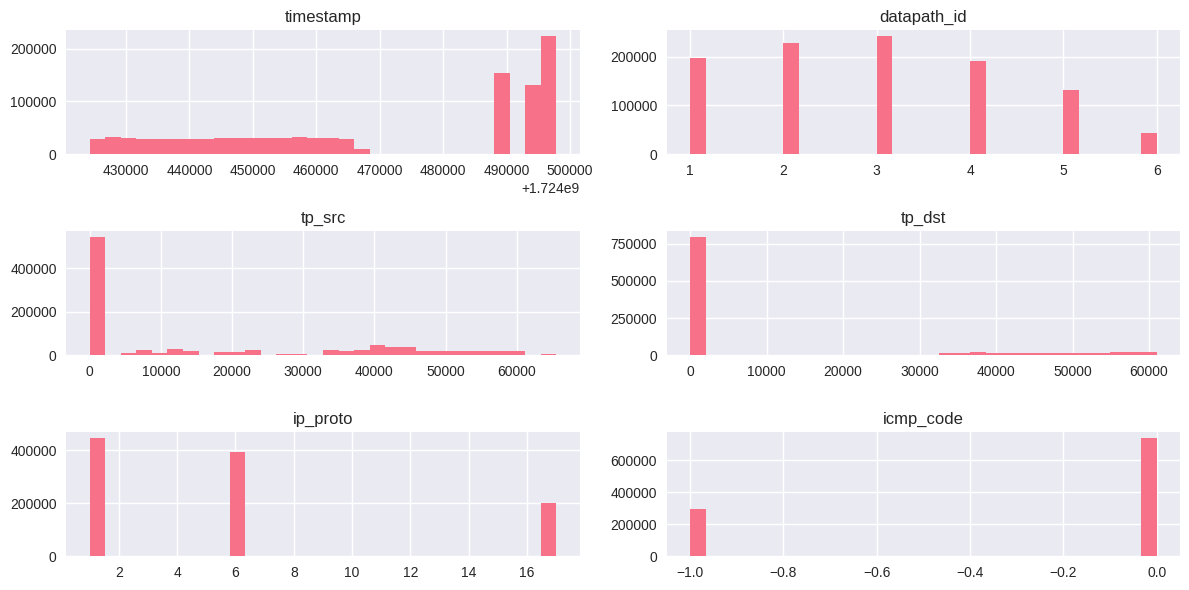

In [4]:
# ==========================================
# 3. EXPLORATORY DATA ANALYSIS (on your real data)
# ==========================================
def perform_eda_real(df, max_display=10):
    print("=" * 50)
    print("EXPLORATORY DATA ANALYSIS (REAL DATA)")
    print("=" * 50)
    print("Shape:", df.shape)
    print("\nData types (top):")
    print(df.dtypes.head(max_display))
    print("\nLabel distribution (counts & %):")
    print(df['label'].value_counts())
    print((df['label'].value_counts(normalize=True)*100).round(3))
    # Basic hist of numeric columns (a few)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) > 0:
        display_cols = numeric_cols[:6]
        df[display_cols].hist(bins=30, figsize=(12,6))
        plt.tight_layout()
        plt.show()
    return numeric_cols

numeric_cols = perform_eda_real(df)

In [7]:
# ==========================================
# 4. PREPROCESSING (categorical encoding, target creation)
# ==========================================
def preprocess_real(df):
    df_proc = df.copy()
    # Drop columns that are non-informative or may leak target (you can adjust)
    # e.g., flow_id may be concatenated; timestamp may be OK but drop it if not needed
    drop_cols = []
    # If there are raw IP columns and you prefer not to use them, drop or encode them:
    # e.g., 'ip_src', 'ip_dst', 'flow_id' might be high-cardinality strings -> drop or encode
    for c in ['flow_id','ip_src','ip_dst']:
        if c in df_proc.columns:
            drop_cols.append(c)
    # Keep datapath_id if useful; treat as categorical
    # Drop chosen columns
    df_proc.drop(columns=drop_cols, inplace=True, errors='ignore')

    # Categorical columns (non-numeric excluding label)
    cat_cols = df_proc.select_dtypes(include=['object', 'category']).columns.tolist()
    cat_cols = [c for c in cat_cols if c != 'label']
    label_encoders = {}
    for c in cat_cols:
        le = LabelEncoder()
        df_proc[c] = df_proc[c].astype(str).fillna('NAN')
        df_proc[c] = le.fit_transform(df_proc[c])
        label_encoders[c] = le

    # Fill remaining numeric NaNs with median
    num_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != 'label']
    df_proc[num_cols] = df_proc[num_cols].fillna(df_proc[num_cols].median())

    # Feature/target split
    X = df_proc.drop(columns=['label'])
    y_binary = (df_proc['label'] != 1).astype(int)  # per your description: 1 = normal, 0 = DDoS -> create binary attack flag
    # Also multiclass: if original labels had attack types, keep original label values; here we only have 0/1 so multiclass same as binary
    y_multiclass = df_proc['label'].astype(int)

    return X, y_binary, y_multiclass, label_encoders

X, y_binary, y_multiclass, label_encoders = preprocess_real(df)
print("Feature matrix shape:", X.shape)
print("Binary target distribution:", np.bincount(y_binary))

Feature matrix shape: (1034668, 18)
Binary target distribution: [507093 527575]


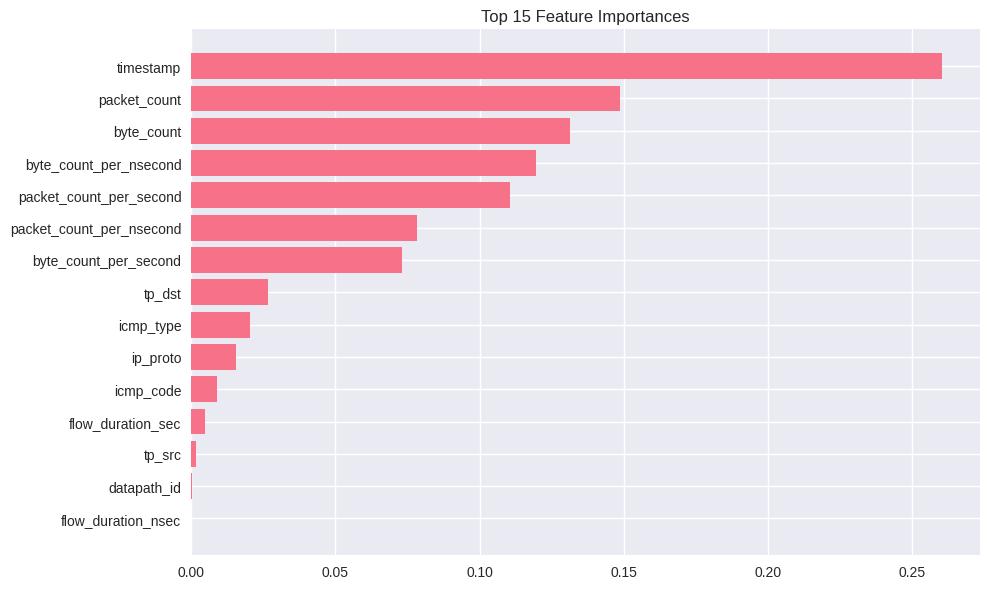

In [8]:
# ==========================================
# 5. FEATURE SELECTION & SCALING (using your pipeline)
# ==========================================
def prepare_features_real(X, y, n_top=20):
    rf_temp = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    rf_temp.fit(X, y)
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_temp.feature_importances_
    }).sort_values('importance', ascending=False)
    top_features = feature_importance.head(n_top)['feature'].tolist()
    scaler = StandardScaler()
    X_selected = X[top_features]
    X_scaled = pd.DataFrame(scaler.fit_transform(X_selected), columns=top_features)
    # plot
    plt.figure(figsize=(10,6))
    plt.barh(feature_importance.head(15)['feature'][::-1], feature_importance.head(15)['importance'][::-1])
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()
    return X_scaled, scaler, top_features, feature_importance

X_scaled, scaler, top_features, feature_importance = prepare_features_real(X, y_binary)

In [13]:
# ==========================================
# 6. TRAIN & EVALUATE MODELS (FAST VERSION with external multiclass fix)
# ==========================================
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import numpy as np

def train_and_evaluate_models_fast(X, y, task_type="binary"):
    print("="*50)
    print("MODEL TRAINING -", task_type)
    print("="*50)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Train:", X_train.shape, "Test:", X_test.shape)

    # Faster balancing: undersample majority
    sampler = RandomUnderSampler(random_state=42)
    X_train_bal, y_train_bal = sampler.fit_resample(X_train, y_train)
    print("After UnderSampling:", np.bincount(y_train_bal))

    # Define lighter models
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=50, max_depth=6, random_state=42, n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=50, max_depth=4, learning_rate=0.1,
            random_state=42,
            eval_metric='logloss' if task_type=='binary' else 'mlogloss'
        ),
        'Decision Tree': DecisionTreeClassifier(
            max_depth=6, random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            random_state=42, max_iter=500, n_jobs=-1
        )
    }

    results = {}
    for name, model in models.items():
        print("Training:", name)
        model.fit(X_train_bal, y_train_bal)

        # Predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(
            y_test, y_pred,
            average='weighted' if task_type=="multiclass" else 'binary'
        )

        roc = None
        if task_type == "binary" and y_proba is not None:
            roc = roc_auc_score(y_test, y_proba[:,1])
        elif task_type == "multiclass" and y_proba is not None:
            roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')

        results[name] = {
            'model': model, 'accuracy': acc, 'f1_score': f1,
            'roc_auc': roc, 'predictions': y_pred
        }
        print(f"{name} -> acc: {acc:.4f} f1: {f1:.4f} roc: {roc if roc else 'N/A'}")

    return results, X_test, y_test


# ==========================================
# Run Training (Fast)
# ==========================================
print("Running binary classification training...")
binary_results, X_test_bin, y_test_bin = train_and_evaluate_models_fast(
    X_scaled, y_binary, task_type="binary"
)

print("\nRunning multiclass training (if applicable)...")

# 🔧 ENHANCED FIX: Properly handle multiclass target conversion
print(f"Original y_multiclass shape: {y_multiclass.shape}")
print(f"Original y_multiclass type: {type(y_multiclass)}")

# Check if it's one-hot encoded (2D with multiple columns)
if len(y_multiclass.shape) > 1 and y_multiclass.shape[1] > 1:
    print("Converting one-hot encoded labels to single label vector...")
    y_multiclass_fixed = np.argmax(y_multiclass, axis=1)
else:
    # If it's already 1D or single column, flatten it
    y_multiclass_fixed = y_multiclass.ravel()

print(f"Fixed y_multiclass shape: {y_multiclass_fixed.shape}")
print(f"Unique classes in y_multiclass: {np.unique(y_multiclass_fixed)}")

# Additional check: ensure it's truly 1D
if len(y_multiclass_fixed.shape) > 1:
    y_multiclass_fixed = y_multiclass_fixed.flatten()
    print(f"After flattening: {y_multiclass_fixed.shape}")

# Check if we have enough classes for multiclass
unique_classes = np.unique(y_multiclass_fixed)
if len(unique_classes) <= 2:
    print(f"Warning: Only {len(unique_classes)} unique classes found. This might be binary classification.")
    print(f"Unique classes: {unique_classes}")

# Only proceed with multiclass if we have more than 2 classes
if len(unique_classes) > 2:
    multiclass_results, X_test_multi, y_test_multi = train_and_evaluate_models_fast(
        X_scaled, y_multiclass_fixed, task_type="multiclass"
    )
else:
    print("Skipping multiclass training - insufficient unique classes for multiclass classification.")
    multiclass_results = None

Running binary classification training...
MODEL TRAINING - binary
Train: (827734, 18) Test: (206934, 18)
After UnderSampling: [405674 405674]
Training: Random Forest
Random Forest -> acc: 1.0000 f1: 1.0000 roc: 1.0
Training: XGBoost
XGBoost -> acc: 1.0000 f1: 1.0000 roc: 0.9999999998598291
Training: Decision Tree
Decision Tree -> acc: 1.0000 f1: 1.0000 roc: 1.0
Training: Logistic Regression
Logistic Regression -> acc: 1.0000 f1: 1.0000 roc: 1.0000000000000002

Running multiclass training (if applicable)...
Original y_multiclass shape: (1034668,)
Original y_multiclass type: <class 'pandas.core.series.Series'>
Fixed y_multiclass shape: (1034668,)
Unique classes in y_multiclass: [0 1]
Unique classes: [0 1]
Skipping multiclass training - insufficient unique classes for multiclass classification.


Binary evaluation:
Best model: Random Forest Accuracy: 1.0


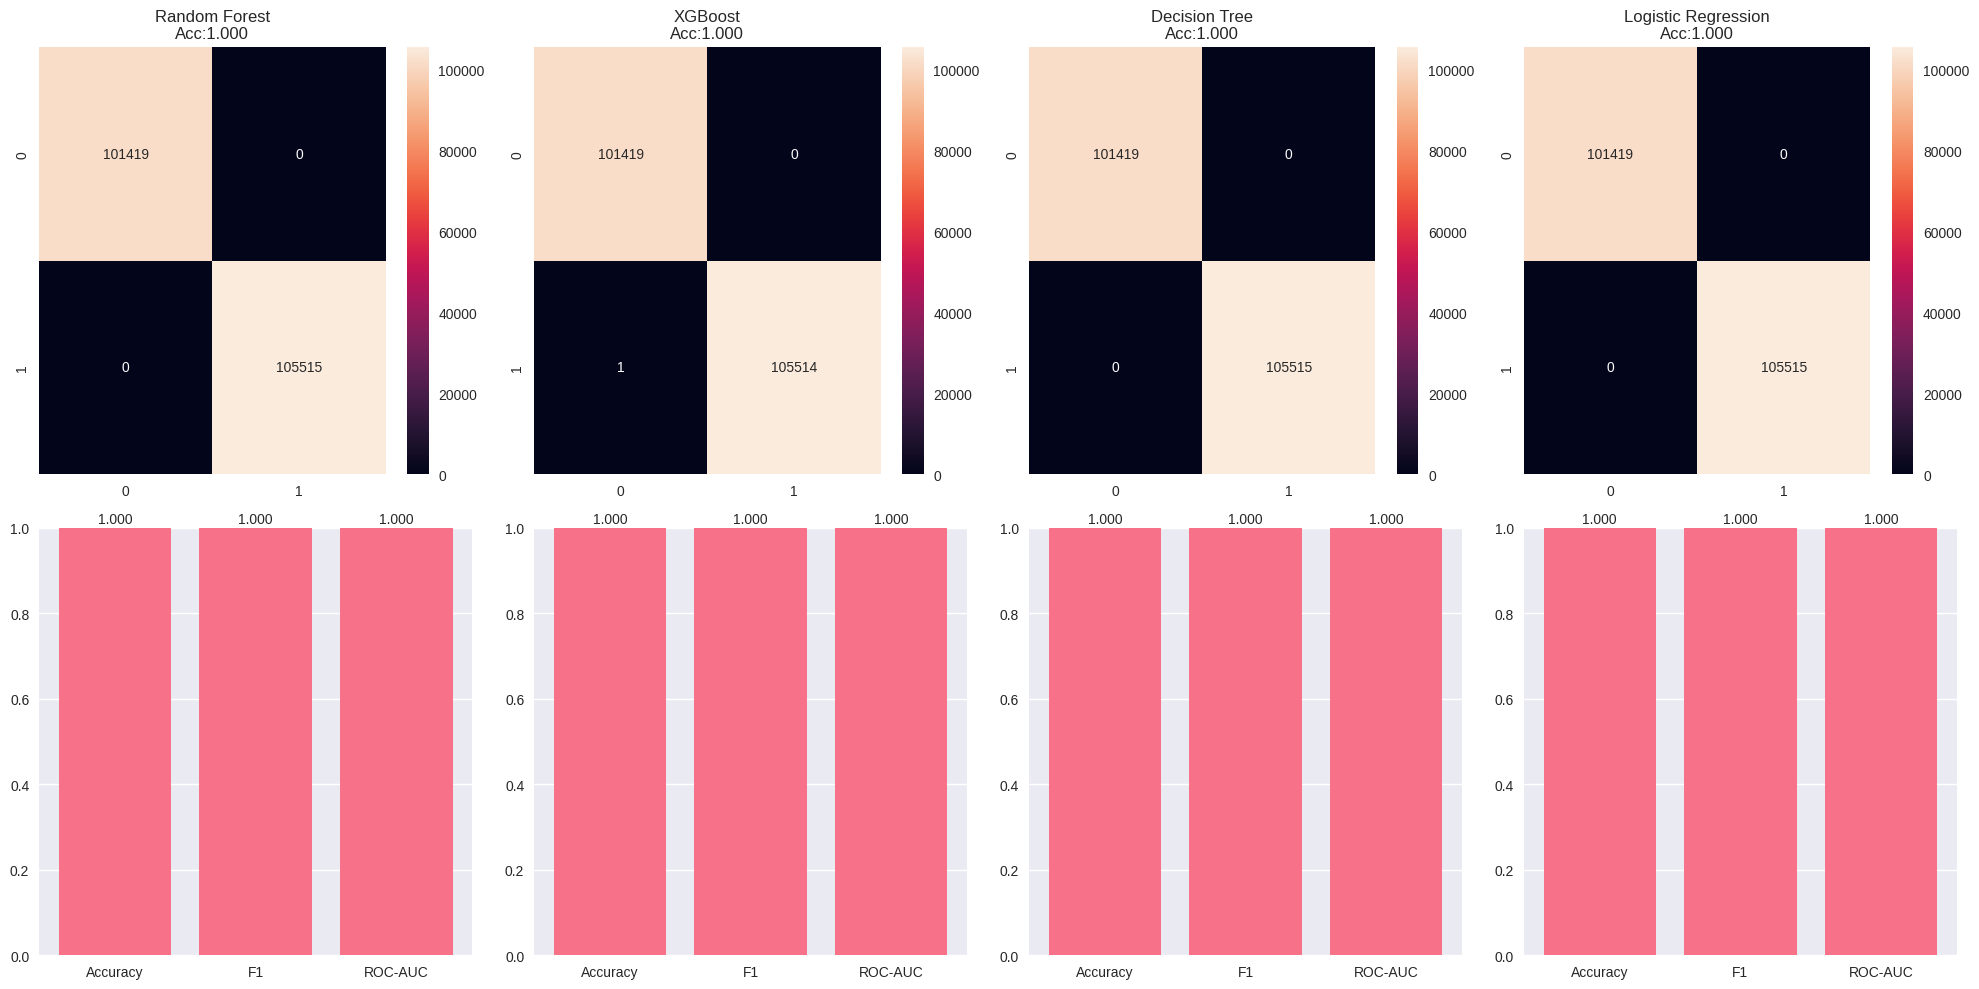


Classification report for best model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101419
           1       1.00      1.00      1.00    105515

    accuracy                           1.00    206934
   macro avg       1.00      1.00      1.00    206934
weighted avg       1.00      1.00      1.00    206934

              Model  Accuracy       F1  ROC-AUC
      Random Forest  1.000000 1.000000      1.0
      Decision Tree  1.000000 1.000000      1.0
Logistic Regression  1.000000 1.000000      1.0
            XGBoost  0.999995 0.999995      1.0

Multiclass evaluation:


NameError: name 'X_test_multi' is not defined

In [15]:
# ==========================================
# 7. DETAILED EVALUATION & REPORTING
# ==========================================
def detailed_evaluation_real(results, X_test, y_test, task_type, le_target=None):
    best_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
    best = results[best_name]
    print("Best model:", best_name, "Accuracy:", best['accuracy'])
    # Confusion matrices and metric bars
    n = len(results)
    fig, axes = plt.subplots(2, n, figsize=(5*n, 10))
    if n == 1:
        axes = axes.reshape(2,1)
    for i,(name,res) in enumerate(results.items()):
        cm = confusion_matrix(y_test, res['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[0,i])
        axes[0,i].set_title(f"{name}\nAcc:{res['accuracy']:.3f}")
        metrics = ['Accuracy','F1']
        vals = [res['accuracy'], res['f1_score']]
        if res['roc_auc'] is not None:
            metrics.append('ROC-AUC'); vals.append(res['roc_auc'])
        axes[1,i].bar(metrics, vals)
        axes[1,i].set_ylim(0,1)
        for j,v in enumerate(vals):
            axes[1,i].text(j, v+0.01, f"{v:.3f}", ha='center')
    plt.tight_layout(); plt.show()
    print("\nClassification report for best model:")
    print(classification_report(y_test, best['predictions']))
    summary = pd.DataFrame([
        {'Model':name, 'Accuracy':res['accuracy'], 'F1':res['f1_score'], 'ROC-AUC': (res['roc_auc'] if res['roc_auc'] else 0)}
        for name,res in results.items()
    ]).sort_values('Accuracy', ascending=False)
    print(summary.to_string(index=False))
    return best_name, summary

print("Binary evaluation:")
best_binary_model, binary_summary = detailed_evaluation_real(binary_results, X_test_bin, y_test_bin, "binary")

print("\nMulticlass evaluation:")
best_multiclass_model, multiclass_summary = detailed_evaluation_real(multiclass_results, X_test_multi, y_test_multi, "multiclass")

In [ ]:
# ==========================================
# 8. HYPERPARAMETER TUNING (example: tune the best binary model)
# ==========================================
def hyperparameter_tuning_real(X, y, model_name='Random Forest', task_type='binary'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    if model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        param_grid = {
            'n_estimators': [50,100,200],
            'max_depth': [5,10,15,None],
            'min_samples_split': [2,5,10]
        }
    elif model_name == 'XGBoost':
        model = xgb.XGBClassifier(random_state=42, eval_metric='logloss' if task_type=='binary' else 'mlogloss')
        param_grid = {'n_estimators':[50,100,200], 'max_depth':[3,6,9], 'learning_rate':[0.01,0.1]}
    else:
        print("Tuning not implemented for", model_name)
        return None
    gs = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    gs.fit(X_train_bal, y_train_bal)
    best_model = gs.best_estimator_
    print("Best params:", gs.best_params_)
    y_pred = best_model.predict(X_test)
    print("Test accuracy:", accuracy_score(y_test, y_pred))
    print("Test F1:", f1_score(y_test, y_pred, average='binary' if task_type=='binary' else 'weighted'))
    return best_model, gs.best_params_

# Example: tune Random Forest for binary
best_rf_tuned, rf_params = hyperparameter_tuning_real(X_scaled, y_binary, model_name='Random Forest', task_type='binary')

In [ ]:
# ==========================================
# 9. FINAL SUMMARY (printout)
# ==========================================
print("\n" + "="*60)
print("FINISHED: SNT DDoS DETECTION PIPELINE (using your uploaded CSV)")
print("="*60)
print("\nDataset summary:")
print(" - Rows:", df.shape[0])
print(" - Columns:", df.shape[1])
print("\nTop feature importances (top 10):")
print(feature_importance.head(10).to_string(index=False))

print("\nBest binary model (from evaluation):", best_binary_model)
print("\nBinary summary:\n", binary_summary)
print("\nBest multiclass model (from evaluation):", best_multiclass_model)
print("\nMulticlass summary:\n", multiclass_summary)
print("\nYou can now:")
print(" - Save the best model with joblib/pickle and deploy to your SDN controller")
print(" - Export feature_importance, or run more tuning / cross-validation")

In [ ]:
# OPTIONAL: Save trained best model to Drive / Colab
import joblib
joblib.dump(best_rf_tuned, '/content/best_rf_tuned_snt.pkl')
print("Saved tuned RF model to /content/best_rf_tuned_snt.pkl")